# Preprocessing Test Data

In [3]:
import skimage.io
from skimage import exposure, filters
import numpy as np
from transformers import TrOCRProcessor, VisionEncoderDecoderModel
from PIL import Image
import requests
import os
import glob
import pandas as pd

In [ ]:
predicted_df = pd.read_csv()

In [92]:
# Load the image
image = skimage.io.imread('./Test-Data/DataTest8.png')

In [94]:
# Enhance the image using contrast stretching
percentiles = np.percentile(image, (50, 90))
enhanced = exposure.rescale_intensity(image, in_range=tuple(percentiles))

In [8]:
# Apply a sharpening filter
sharpened = filters.unsharp_mask(enhanced, radius=1.0, amount=1.0, multichannel=True)

/var/folders/ht/1vg09v7x16x7sbqnmzfvc4600000gn/T/ipykernel_73364/3024815230.py:2: FutureWarning: `multichannel` is a deprecated argument name for `unsharp_mask`. It will be removed in version 1.0. Please use `channel_axis` instead.
  sharpened = filters.unsharp_mask(enhanced, radius=1.0, amount=1.0, multichannel=True)


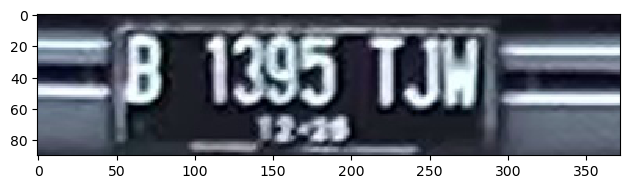

In [93]:
skimage.io.imshow(image)

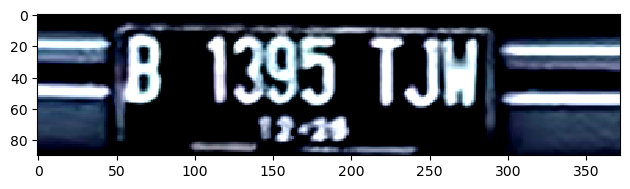

In [95]:
skimage.io.imshow(enhanced)

In [96]:
from skimage.color import rgb2gray

In [97]:
grayscale = rgb2gray(enhanced)*255

In [83]:
from skimage import util 

In [98]:
#grayscale_inv = util.invert(grayscale)

In [104]:
grayscale_inv_im = Image.fromarray(grayscale.astype('uint8'))

In [105]:
grayscale_inv_im = grayscale_inv_im.convert("RGB")

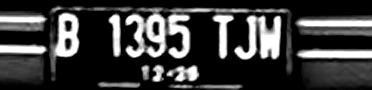

In [106]:
grayscale_inv_im

In [2]:
processor = TrOCRProcessor.from_pretrained('./tr-ocr-fine-tuned2', local_files_only=True)
model = VisionEncoderDecoderModel.from_pretrained('./tr-ocr-fine-tuned2', local_files_only=True)

In [107]:
pixel_values = processor(images=grayscale_inv_im, return_tensors="pt").pixel_values
generated_ids = model.generate(pixel_values)
generated_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]

In [108]:
generated_text

'B1395TJW'

## Calculating Accuracy After Increasing Contrast

In [111]:
labels_csv = pd.read_csv('/Users/rsoedarnadi/Documents/GitHub/bdc-team4/DataTestLabelled.csv', delimiter=',')
list_license_plates = labels_csv['Image Labels']
list_file_names = labels_csv['Name of File']

In [123]:
generated_plate_numbers = []

In [127]:
for file in list_file_names:
    path = os.path.join(os.getcwd(), 'Test-Data', file)
    image = skimage.io.imread(path)
    percentiles = np.percentile(image, (50, 90))
    enhanced = exposure.rescale_intensity(image, in_range=tuple(percentiles))
    enhanced_im = Image.fromarray(enhanced.astype('uint8'))
    enhanced_im = enhanced_im.convert("RGB")
    pixel_values = processor(images=enhanced_im, return_tensors="pt").pixel_values
    generated_ids = model.generate(pixel_values)
    generated_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
    generated_plate_numbers.append(generated_text)

/Users/rsoedarnadi/opt/anaconda3/lib/python3.9/site-packages/transformers/generation/utils.py:1353: UserWarning: Using `max_length`'s default (64) to control the generation length. This behaviour is deprecated and will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


In [125]:
def calculate_predicted_accuracy(names, actual_list, predicted_list):
    list_accuracy = []
    for name, actual_plate, predict_plate in zip(names, actual_list, predicted_list):
        accuracy = 0
        num_matches = 0
        if actual_plate == predict_plate:
            accuracy = 1.0
        else:
            for a, p in zip(actual_plate, predict_plate):
                if a == p:
                    num_matches += 1
            accuracy = round((num_matches / len(actual_plate)), 2)
        list_accuracy.append(accuracy)
    list_accuracy = np.asarray(list_accuracy)
    avg_value = np.average(list_accuracy)
    return avg_value

In [132]:
calculate_predicted_accuracy(list_file_names, list_license_plates, generated_plate_numbers)

0.9292

## Trying Detection Using OpenCV

In [1]:
import numpy as np
import cv2 
import imutils

In [18]:
img = cv2.imread('/Users/rsoedarnadi/Documents/GitHub/bdc-team4/Test-Data/DataTest1.png')

In [19]:
cv2.imshow('ImageWindow',img)
cv2.waitKey()

27

In [20]:
#Converting the image to gray-scale
image_gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
#Blurring the image with a 11x11 mask
blured_image = cv2.GaussianBlur(image_gray,(11,11),0)
#Finding the edges of the non blurred image
edge_image_blur = cv2.Canny(blured_image,30,100)
#Finding the edges of blurred image
edge_image_normal = cv2.Canny(image_gray,30,100)

In [25]:
cv2.imshow('ImageWindow',edge_image_blur)
cv2.waitKey()

27

In [26]:
#Finding points of contours
key_points =cv2.findContours(edge_image_blur,cv2.RETR_LIST,cv2.CHAIN_APPROX_SIMPLE)
#defining contours from keypoints
contours = imutils.grab_contours(key_points)
#drawing contours
cv2.drawContours(edge_image_blur, contours, -1, (0,255,0), 3)
cv2.imshow('Imagewindow',img)
cv2.waitKey()

27

In [27]:
contours = sorted(contours, key=cv2.contourArea, reverse=True)[:20]
plate_location = None
for cnt in contours:
 sqaure_approx = cv2.approxPolyDP(cnt, 10, True)
 if len(sqaure_approx) == 4:
   plate_location = sqaure_approx

print(plate_location)

[[[195  37]]

 [[191  73]]

 [[195  43]]

 [[184  43]]]


In [28]:
x1, x2 = min(plate_location[:,0][:,1]), max(plate_location[:,0][:,1])
y1, y2 = min(plate_location[:,0][:,0]), max(plate_location[:,0][:,0])
cropped_image = img[x1:x2, y1:y2]
cv2.imshow('Imagewindow',cropped_image)
cv2.waitKey()

27

## Trying Cropping Using Haar Cascade

In [30]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

In [31]:
# Loads the data required for detecting the license plates from cascade classifier.
plate_cascade = cv2.CascadeClassifier('/Users/rsoedarnadi/Downloads/plat-80-25stage.xml')

In [32]:
# Testing the above function
def display(img_, title=''):
    img = cv2.cvtColor(img_, cv2.COLOR_BGR2RGB)
    fig = plt.figure(figsize=(10,6))
    ax = plt.subplot(111)
    ax.imshow(img)
    plt.axis('off')
    plt.title(title)
    plt.show()


display(img, 'input image')

[ WARN:0@3766.004] global /Users/runner/work/opencv-python/opencv-python/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('/Users/rsoedarnadi/Documents/GitHub/bdc-team4/Data Train for BDC 2023 - Penyisihan/license-plates/DataTrain56.png'): can't open/read file: check file path/integrity


error: OpenCV(4.6.0) /Users/runner/work/opencv-python/opencv-python/opencv/modules/imgproc/src/color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'
